# Maaşa Dayalı Emeklilik Modeli Monte Carlo Simülasyonu 

Çalışma problemimiz, bireylerin emeklilik hedeflerine ulaşabilmek için ne kadar süre boyunca birikim yapmaları gerektiğini hesaplamak üzerine odaklanmaktadır. Bu hesaplama, bir dizi girdi parametresine dayanır ve bireyin başlangıç maaşından itibaren ne kadar biriktirdiği ve yatırım getirisiyle nasıl büyüdüğü gibi faktörleri dikkate alır. Ayrıca, maaş artışları, terfiler ve yaşam maliyeti artışları gibi faktörlerin de emeklilik yılına olan etkileri değerlendirilir.

Bu problemi çözmek için, bir Python modeli geliştirdik. Model, başlangıç maaşını, terfi sıklığını, yaşam maliyeti artışlarını, terfi zam oranını, biriktirme oranını ve yatırım getirisini dikkate alarak yıllara göre birikimi hesaplar. Ardından, bir bireyin emeklilik hedefine ulaşması için geçmesi gereken yılları belirler. Ayrıca, Monte Carlo simülasyonu kullanarak farklı senaryoları değerlendirir ve girdi parametrelerinin emeklilik yılına olan etkisini analiz eder.

Model akışımızı aşağıdaki gibidir:
- [**Gerekli Modüllerin İçe Aktarılması**](#Gerekli-Modüllerin-İçe-Aktarılması): İmport işlemleri ve diğer ön ayarlar yapılır.
- [**Girdiler**](#Girdiler): Model için girdiler tanımlanır.
- [**Maaşlar**](#SMaaşlar)S: Her yıldaki maaşı belirleme işlemi yapılır, yaşam maliyeti artışları ve terfiler dikkate alınır.
- [**Varlıklar**](#Varlıklar): Her yıldaki birikimi belirleme işlemi yapılır, sabit birikim oranı ve yatırım oranı dikkate alınır.
- [**Emeklilik**](#Emeklilik): Zaman içindeki birikimlere dayanarak emeklilik yılı belirlenir, modelin temel çıktısıdır.
- [**Sonuçların Özeti**](#Sonuçların-Özeti): Sonuçların bazı görselleştirmelerle özetlenmesi.
- [**Sonuçların Analizi**](#Sonuçların-Analizi): Sensitivity Analysis: Emeklilik yıllarının model girdilerine ne kadar hassas olduğunun belirlenmesi.

**Çalışma problemi için kullanılan değişkenlerin ve tanımları:**

-**Başlangıç Maaşı (Starting Salary)**: Bireyin çalışmaya başladığı yılda kazandığı maaş miktarı. Bu değer, birikim hesaplamasının temelini oluşturur.

-**Terfi Sıklığı (Promotions Every N Years)**: Bireyin kaç yılda bir terfi alacağını belirten bir parametre. Bu parametre, maaş artışını ve birikimi etkiler.

-**Yaşam Maliyeti Artışı (Cost of Living Raise)**: Yıllık yaşam maliyetlerindeki artış oranını ifade eder. Bu değer, maaş artışı ve birikim hesaplamalarında kullanılır.

-**Terfi Zam Oranı (Promotion Raise)**: Terfi alındığında maaşta meydana gelen artış oranıdır. Terfi zamı, maaş artışını ve birikimi etkiler.

-**Biriktirme Oranı (Savings Rate)**: Bireyin maaşının bir yüzdesi olarak biriktirdiği orandır. Bu değer, birikim hesaplamalarında kullanılır.

-**Faiz Oranı (Faiz Oranı)**: Yatırımların yıllık getiri oranını ifade eder. Birikimler, bu getiri oranına göre büyür.

Bu değişkenler, emeklilik yılı hesaplamaları ve Monte Carlo simülasyonları için temel parametreleri oluşturur. Bu değerlerin farklı kombinasyonları, bireyin emeklilik hedeflerine ulaşmak için geçmesi gereken yılları etkiler.

## Gerekli Modüllerin İçe Aktarılması



In [59]:
from dataclasses import dataclass
import pandas as pd
%matplotlib inline
import random
import statsmodels.api as sm

## Girdiler

Model için gerekli tüm girdileri tanımlıyoruz. Ve bunları bir sınıfta topluyoruz.

ModelInputs adlı sınıf, emeklilik modelinin girişlerini temsil eder. starting_salary(başlangıç maaşı, promos_every_n_years(terfi yılı), cost_of_living_raise(yaşam maliyeti artışı), promo_raise(promosyon artışı), savings_rate(tasarruf oranı), interest_rate(yatırım oranı) ve desired_cash(hedeflenen miktar) gibi veri alanları bulunur. Bu veri alanları, emeklilik modelinde kullanılan giriş parametrelerini temsil eder. Ayrıca, her veri alanı için varsayılan değerler de belirtilmiştir.

In [60]:
@dataclass
class ModelInputs:
    başlangıç_maaşı: int = 60000
    terfi_sıklığı: int = 5
    yaşam_maliyeti_artışı: float = 0.02
    terfi_zam_oranı: float = 0.15
    biriktirme_oranı: float = 0.25
    faiz_oranı: float = 0.05
    hedef_nakit: int = 1500000
        
model_verileri = ModelInputs()

## Maaşlar

Maaşların her yıl için yaşam maliyeti artışlarına göre sabit bir oranda arttığı ve ardından terfi veya iş değiştirme nedeniyle her yıl daha fazla arttığı varsayımına dayanarak, maaş aşağıdaki denklemle zaman içinde gelişecektir.

$$s_t = s_0 (1 + r_{cl})^n (1 + r_p)^p$$


- $s_t$: Yıllık Maaş $t$
- $s_0$: Başlangıç Maaşı (0. yıl)
- $r_{cl}$: Yıllık yaşam maliyeti artışı
- $r_p$: Terfi zam oranı
- $p$: Terfi sayısı

Bu formül, bir kişinin $t$ yılındaki yıllık maaşını, $s_t$, hesaplamak için kullanılır. Yaşam maliyetlerindeki yıllık artışı ve terfi sayısını dikkate alarak, başlangıç maaşından bu yana ne kadar bir artış olacağını belirler.

Örneğin, başlangıç maaşınızın 50000 TL olduğunu, yaşam maliyetlerinin(enflasyon) yılda %2 arttığını, terfi ile gelen zam oranının %10 olduğunu ve 5 yıl içinde 2 kez terfi ettiğinizi varsayalım. Bu durumda, 5. yıldaki maaşınızı hesaplamak için:

$$
s_5 = 50000 \times (1 + 0.02)^5 \times (1 + 0.10)^2
$$

Bu işlemi gerçekleştirdikten sonra 5. yıldaki maaşınızı bulabilirsiniz.



In [62]:
def yıldaki_maaş(data: ModelInputs, yıl):
    """
    Başlangıçtan itibaren yaşam maliyeti artışlarına ve düzenli terfilerine dayalı olarak belirli bir yıldaki maaşı elde eder.
    """
    # Her n yılda bir terfi yapılır, bu nedenle yılları böler ve ondalıkları çıkartarak terfi sayısını elde ederiz
    terfi_sayısı = int(yıl / data.terfi_sıklığı)
    
    # Yukarıdaki formülü Python'da uyguladık
    maaş_t = data.başlangıç_maaşı * (1 + data.yaşam_maliyeti_artışı) ** yıl * (1 + data.terfi_zam_oranı) ** terfi_sayısı
    return maaş_t

Bu fonksiyon, belirli bir yılda maaşı almak için kullanılır. Dolayısıyla, tüm maaşları elde etmek için bu fonksiyonu her yıl çalıştırmamız gerekir. Ancak, birey emekli olana kadar kaç yıl çalıştırmamız gerektiğini bilemeyiz. Şu anda sadece ilk birkaç maaşı gösteriyoruz ve daha sonra bu fonksiyonu modelin Varlıklar bölümünde kullanacağız.

In [63]:
for i in range(6):
    yıl = i + 1
    maaş = yıldaki_maaş(model_verileri, yıl)
    print(f'{yıl}. yıldaki maaş: {maaş:,.0f} TL.')

1. yıldaki maaş: 61,200 TL.
2. yıldaki maaş: 62,424 TL.
3. yıldaki maaş: 63,672 TL.
4. yıldaki maaş: 64,946 TL.
5. yıldaki maaş: 76,182 TL.
6. yıldaki maaş: 77,705 TL.


Beklendiği gibi, varsayılan girdilerle maaş yılda %2 oranında artmaktadır. Ancak, 5. yılda bir terfi olduğu için maaşta daha büyük(15%) bir artış olmaktadır.

## Varlıklar

Modelin varlıklar bölümü, kazanılan maaşa birikim oranını uygulayarak biriktirilen nakit miktarını hesaplar, zamanla biriken nakiti büyür ve biriktirilen varlığa faiz  uygulanır.

Nakit biriktirme miktarını hesaplamak için kullanılan formül basittir:

$$c_t = s_t * r_s$$

- $s_t$: Yıllık Maaş $t$
- $c_t$: Yıl boyunca biriktilen nakit $t$
- $r_s$: Tasarruf(biriktirme) oranı

In [64]:
def yıl_boyunca_biriktirilen_nakit(data: ModelInputs, yıl):
    """
    Belirli bir yılda biriktirilen nakit miktarını hesaplar. İlk olarak, o yıldaki maaşı hesaplayarak birikim oranını
    uygular.
    """
    maaş = yıldaki_maaş(data, yıl)
    biriktirilen_nakit = maaş * data.biriktirme_oranı
    return biriktirilen_nakit


Her yıldaki varlığı elde etmek için, önceki yılın varlığına yatırım getirisini uygulayarak bu yıl biriktirilen nakiti eklemek gerekmektedir.

$$w_t = w_{t-1} (1 + r_i) + c_t$$

- $w_t$: Yıldaki varlık miktarı $t$
- $r_i$: Yatırım oranı


Örneğin, geçen yılın sonunda 10.000 TL'niz vardı ve yatırım getiri oranınız %5 (yani 0.05 olarak ifade edilir) idi. Bu yıl içerisinde de 2.000 TL biriktirdiniz. Yıl sonundaki toplam varlığınızı bulmak için formülü şu şekilde uygulayabiliriz:

$$
w_t = w_{t-1} (1 + r_i) + c_t
$$

Burada $w_{t-1}$ geçen yılki varlığınızı (10.000 TL), $r_i$ yatırım getiri oranınızı (%5), ve $c_t$ bu yıl biriktirdiğiniz nakiti (2.000 TL) temsil eder.

$$
w_t = 10,000 \times (1 + 0.05) + 2,000
$$

Bu formülü çözdüğümüzde,

$$
w_t = 10,500 + 2,000 = 12,500
$$

Yani, bu yıl sonunda toplam 12,500 TL varlığınız olur. Bu varlıkların 10,500 TL'si geçen yılki varlığınızın artı yatırım getirisi ve kalan 2,000 TL'si de bu yıl biriktirdiğiniz nakittir.


In [65]:
def yıldaki_varlık(data: ModelInputs, yıl, önceki_varlık):
    """
    Önceki yıldaki varlığa, yatırım oranına ve o yıl boyunca biriktirilen nakit miktarına dayanarak belirli bir yıl için varlığı hesaplar.
    """
    biriktirilen_nakit = yıl_boyunca_biriktirilen_nakit(data, yıl)
    varlık = önceki_varlık * (1 + data.faiz_oranı) + biriktirilen_nakit
    return varlık



Tekrar belirtmek gerekirse,[Maaşlar](#Maaşlar) bölümünde olduğu gibi, şimdi her yıl için çıktıyı alabiliriz, ancak sonunda kaç yıl çalıştıracağımızı bilmiyoruz. Bu,[Emeklilik](#Emeklilik)  bölümünde belirlenecektir. Bu nedenle, şimdilik sadece varlık biriktirmenin ilk birkaç yılını gösterelim:

In [67]:
önceki_varlık = 0  # başlangıçta sıfır varlık ile başlıyoruz
for i in range(6):
    yıl = i + 1
    varlık = yıldaki_varlık(model_verileri, yıl, önceki_varlık)
    print(f'{yıl}. yıldaki varlık {varlık:,.0f} TL.')
    
    # Gelecek yılın önceki varlığı bu yılın varlığı olarak ayarlanır
    önceki_varlık = varlık

1. yıldaki varlık 15,300 TL.
2. yıldaki varlık 31,671 TL.
3. yıldaki varlık 49,173 TL.
4. yıldaki varlık 67,868 TL.
5. yıldaki varlık 90,307 TL.
6. yıldaki varlık 114,248 TL.


Varsayılan girdilerle, servet her yıl maaşın yaklaşık %25'i kadar artıyor, biraz da yatırım getirisi ekleniyor. Sonra 6. yılda, terfi nedeniyle maaşın önemli ölçüde artması sebebiyle, çok daha büyük bir artış görüyoruz.



## Emeklilik

Bu modelin bu bölümü, emeklilik için gereken yılların son sonucunu belirlemek üzere tüm bileşenleri birleştirir.  Her yıl elde edilen birikim, hedeflenen nakit miktarına ulaşıncaya kadar izlenir. Birikim miktarı hedeflenen nakit miktarına ulaştığında, kişi artık emekli olabilir. Bu nedenle, hedeflenen nakit miktarına ulaşılan yıl, emeklilik için gereken yıl olarak kabul edilir.


In [68]:
def emeklilik_yılları(data: ModelInputs, çıktıyı_yazdır=True):
    
    # başlangıçta biriktirilmiş nakit yok
    önceki_varlık = 0  
    varlık = 0
    
    yıl = 0  # ilk döngüde 1 olacak
    
    if çıktıyı_yazdır:
        print('Varlıklar zaman içinde:') # \n çıktıda boş bir satır oluşturur.
    while varlık < data.hedef_nakit:
        yıl = yıl + 1
        varlık = yıldaki_varlık(data, yıl, önceki_varlık)
        if çıktıyı_yazdır:
            print(f'{yıl}. yıldaki varlık {varlık:,.0f} TL.')

        # Gelecek yılın önceki varlığı bu yılın varlığı olarak ayarlanır
        önceki_varlık = varlık
        
    # Şimdi while döngüsünden çıktık, bu yüzden varlık >= hedef_nakit olmalı. Son belirlenen yıl,
    # emeklilik için geçecek yılları temsil eder.
    if çıktıyı_yazdır:
        print(f'\nEmeklilik:\nEmekli olmak için {yıl} yıl gerekecek.')  #  \n çıktıda boş bir satır oluşturur.
    return yıl


Bu Python fonksiyonunun çalışma mantığı 4 ana adımdan oluşmaktadır:

1. Fonksiyon, başlangıçta birikmiş nakit olmadığını varsayar.
2. Her yıl için, birikim miktarı (maaş ve yatırım getirilerinden oluşan) hesaplanır.
3. Birikmiş nakit, hedeflenen nakit miktarına ulaşıncaya kadar her yıl takip edilir.
4. Hedef nakit miktarına ulaşıldığında, o ana kadar geçen yıl sayısı, emeklilik için gerekli yılları temsil eder.

Bu fonksiyon, bir bireyin hedeflenen birikim miktarına ulaşmak için ne kadar süreyle çalışması gerektiğini hesaplar.
``


Varsayılan girdilerle:

In [69]:
yıllar = emeklilik_yılları(model_verileri)

Varlıklar zaman içinde:
1. yıldaki varlık 15,300 TL.
2. yıldaki varlık 31,671 TL.
3. yıldaki varlık 49,173 TL.
4. yıldaki varlık 67,868 TL.
5. yıldaki varlık 90,307 TL.
6. yıldaki varlık 114,248 TL.
7. yıldaki varlık 139,775 TL.
8. yıldaki varlık 166,975 TL.
9. yıldaki varlık 195,939 TL.
10. yıldaki varlık 229,918 TL.
11. yıldaki varlık 266,080 TL.
12. yıldaki varlık 304,542 TL.
13. yıldaki varlık 345,431 TL.
14. yıldaki varlık 388,878 TL.
15. yıldaki varlık 439,025 TL.
16. yıldaki varlık 492,294 TL.
17. yıldaki varlık 548,853 TL.
18. yıldaki varlık 608,878 TL.
19. yıldaki varlık 672,557 TL.
20. yıldaki varlık 745,168 TL.
21. yıldaki varlık 822,190 TL.
22. yıldaki varlık 903,859 TL.
23. yıldaki varlık 990,422 TL.
24. yıldaki varlık 1,082,140 TL.
25. yıldaki varlık 1,185,745 TL.
26. yıldaki varlık 1,295,520 TL.
27. yıldaki varlık 1,411,793 TL.
28. yıldaki varlık 1,534,910 TL.

Emeklilik:
Emekli olmak için 28 yıl gerekecek.


# Sonuçların Özeti

## Sonuçları bir tabloda gösterme

Şimdi, maaşları ve varlıkları zaman ile görselleştireceğiz. Öncelikle Bu sonuçları bir DataFrame'e yerleştiren modeli çalıştıran bir fonksiyon oluşturmalıyız.

In [70]:
def maaş_varlık_df_al(data):
    """
    Emeklilik modelini çalıştırır, yıl yıl maaş ve varlık bilgilerini toplayarak
    daha sonra analiz için bir DataFrame'e depolar.
    
    """
    # başlangıçta biriktirilmiş nakit yok
    önceki_varlık = 0  
    varlık = 0
    
    yıl = 0  # ilk döngüde 1 olacak
    
    df_veri_tupları = []
    while varlık < data.hedef_nakit:
        yıl = yıl + 1
        maaş = yıldaki_maaş(data, yıl)
        varlık = yıldaki_varlık(data, yıl, önceki_varlık)

        # Gelecek yılın önceki varlığı bu yılın varlığı olarak ayarlanır
        önceki_varlık = varlık
        
        # Sonuçları DataFrame'e yerleştirmek için bir tuple olarak kaydet
        df_veri_tupları.append((yıl, maaş, varlık))
        
    # Artık while döngüsünden çıktık, bu yüzden varlık >= hedef_nakit olmalı
    
    # Şimdi DataFrame'i oluştur
    df = pd.DataFrame(df_veri_tupları, columns=['Yıl', 'Maaş', 'Varlık'])
    
    return df


Fonksiyon şu şekilde çalışır:

1. Fonksiyon, başlangıçta birikmiş nakit olmadığını varsayar.
2. Her yıl için, yıldaki_maaş ve yıldaki_varlık fonksiyonları kullanılarak o yıldaki maaş ve birikim miktarı hesaplanır.
3. Hesaplanan maaş ve birikim miktarı, her yıl için bir demet (tuple) oluşturarak listeye eklenir.
4. Bu işlem, birikim miktarı hedeflenen nakit miktarına ulaşıncaya kadar her yıl için tekrarlanır.
5. Daha sonra, maaş ve birikim miktarlarından oluşan liste, pandas DataFrame'ine dönüştürülür ve bu DataFrame döndürülür.

In [71]:
def stil_uygula_maaş_varlık(df):
    return df.style.format({
        'Maaş': '{:,.2f} TL',
        'Varlık': '{:,.2f} TL'
    })


Şimdi fonksiyonu çağırarak sonuçları DataFrame'e kaydedelim.

In [72]:
df = maaş_varlık_df_al(model_verileri)
stil_uygula_maaş_varlık(df)


,Yıl,Maaş,Varlık
0,1,"61,200.00 TL","15,300.00 TL"
1,2,"62,424.00 TL","31,671.00 TL"
2,3,"63,672.48 TL","49,172.67 TL"
3,4,"64,945.93 TL","67,867.79 TL"
4,5,"76,181.58 TL","90,306.57 TL"
5,6,"77,705.21 TL","114,248.20 TL"
6,7,"79,259.31 TL","139,775.44 TL"
7,8,"80,844.50 TL","166,975.33 TL"
8,9,"82,461.39 TL","195,939.45 TL"
9,10,"96,727.21 TL","229,918.22 TL"


## Grafik sonuçları

Şimdi zamanla maaşları ve servetleri görselleştireceğiz.

### Yıllara göre Maaşlar

<Axes: xlabel='Yıl'>

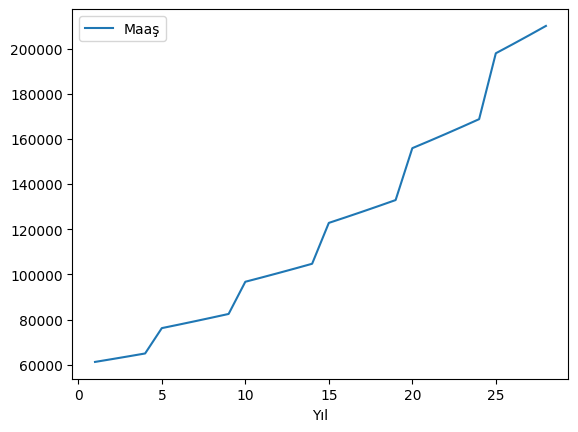

In [73]:
df.plot.line(x='Yıl', y='Maaş')


### Yıllara göre Varlıklar

<Axes: xlabel='Yıl'>

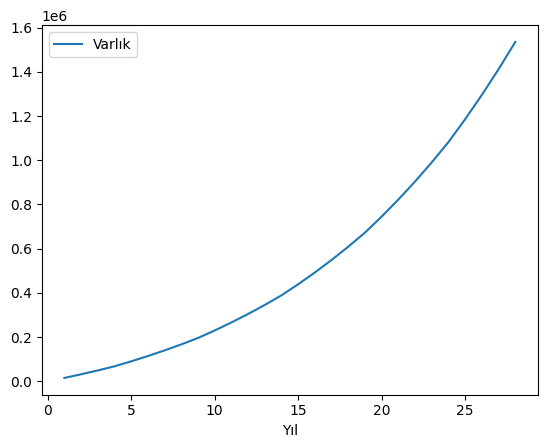

In [74]:
df.plot.line(x='Yıl', y='Varlık')


# Monte Carlo Simülasyonu

Bu simülasyonlarla amaç, emeklilik için farklı yılların olasılıklarını değerlendirmek ve tüm girdilerin değiştiği durumlarda emeklilik için geçen yıl sayısının nasıl etkilendiğini daha iyi anlamaktır.

## Monte Carlo Kurulumu

İlk olarak, her bir girdinin standart sapmalarını ve iterasyon sayısını içeren yeni bir dataclass oluşturacağım. Mevcut girdileri her bir girdinin ortalaması olarak kullanacağım.

> Not : Mevcut `ModelInputs`hala kullanılacak, ancak bu iki `dataclass` birlikte çalışacak

In [75]:
@dataclass
class SimulasyonVerileri:
    n_iterasyonlar: int = 10000
    başlangıç_maaşı_std: int = 10000
    terfi_sıklığı_std: int = 1.5
    yaşam_maliyeti_artışı_std: float = 0.005
    terfi_zam_oranı_std: float = 0.05
    biriktirme_oranı_std: float = 0.07
    faiz_oranı_std: float = 0.01
        
sim_verileri = SimulasyonVerileri()



## Tek Bir Simülasyonun Çalıştırılması

Şimdi, ana model girdilerinin değerlerini normal dağılımlardan seçen ve ardından modeli çalıştırıp hem girdileri hem de emeklilik için geçecek yıl sayısını döndüren bir fonksiyon oluşturacağız.

Simülasyonda anlamsız değerleri elememiz gerekecek. Her bir girdi için, eğer değer sıfırın altına düşerse, yeni bir girdi seçeceğiz.



In [76]:
def rastgele_normal_pozitif(ortalama, std):
    """
    Bu fonksiyon, pozitif bir sayı elde edene kadar normal dağılımdan rastgele sayılar seçmeye devam eder,
    ardından o sayıyı döndürür.
    """
    çekilen_değer = -1  # while döngüsünün başlaması için başlangıçta negatif bir sayıya başlayın
    while çekilen_değer < 0:
        çekilen_değer = random.normalvariate(ortalama, std)
    return çekilen_değer


def emeklilik_simulasyonu_girdileri(veri, sim_veri):
    """
    Aşağıdaki girdileri, ModelInputs değerlerini ortalama olarak kullanarak ve SimulasyonVerileri'ndeki
    _std değerlerini standart sapma olarak kullanarak normal dağılımlardan rastgele seçer:
    - Başlangıç maaşı
    - Terfi sıklığı
    - Yaşam maliyeti artışı
    - Terfi zam oranı
    - Biriktirme oranı
    - Faiz oranı
    

    Ayrıca, herhangi bir seçilen değer sıfır veya daha küçükse, yeniden seçilir.
    """
    başlangıç_maaşı = rastgele_normal_pozitif(veri.başlangıç_maaşı, sim_veri.başlangıç_maaşı_std)
    terfi_sıklığı = rastgele_normal_pozitif(veri.terfi_sıklığı, sim_veri.terfi_sıklığı_std)
    yaşam_maliyeti_artışı = rastgele_normal_pozitif(veri.yaşam_maliyeti_artışı, sim_veri.yaşam_maliyeti_artışı_std)
    terfi_zam_oranı = rastgele_normal_pozitif(veri.terfi_zam_oranı, sim_veri.terfi_zam_oranı_std)
    biriktirme_oranı = rastgele_normal_pozitif(veri.biriktirme_oranı, sim_veri.biriktirme_oranı_std)
    faiz_oranı = rastgele_normal_pozitif(veri.faiz_oranı, sim_veri.faiz_oranı_std)
  
    

    return (
        başlangıç_maaşı,
        terfi_sıklığı,
        yaşam_maliyeti_artışı,
        terfi_zam_oranı,
        biriktirme_oranı,
        faiz_oranı,
      
    )


Her bir parametre için bir "ortalama" ve bir "standart sapma" belirlenmiştir. Ortalama, bu parametrenin "normalde" ne kadar olması gerektiğini belirtir. Standart sapma ise bu parametrenin ne kadar dalgalanabileceğini gösterir.

Örneğin, başlangıç maaşının ortalaması 50,000 TL ve standart sapması 5,000 TL olsun. Bu durumda, simülasyon her çalıştırıldığında, başlangıç maaşı ortalama etrafında dalgalanacak ve genellikle 45,000 TL ile 55,000 TL arasında olacaktır. Ancak burada önemli olan, çekilen rastgele değerlerin her zaman pozitif olacağıdır. Yani, hiçbir zaman negatif bir maaş veya negatif bir oran olmayacaktır.

In [77]:
def tekli_emeklilik_simulasyonu(veri, sim_veri):
    """
    Emeklilik için yılın tek bir Monte Carlo simülasyonunu çalıştırır.
    
    emeklilik_simulasyonu_girdileri fonksiyonunu kullanır.
    """
    # Girdi değerlerini normal dağılımlardan seç
    (
        başlangıç_maaşı,
        terfi_sıklığı,
        yaşam_maliyeti_artışı,
        terfi_zam_oranı,
        biriktirme_oranı,
        faiz_oranı,
        
    ) = emeklilik_simulasyonu_girdileri(veri, sim_veri)
    
    # Model girdilerini oluştur
    yeni_veri = ModelInputs(
        başlangıç_maaşı=başlangıç_maaşı,
        terfi_sıklığı=terfi_sıklığı,
        yaşam_maliyeti_artışı=yaşam_maliyeti_artışı,
        terfi_zam_oranı=terfi_zam_oranı,
        biriktirme_oranı=biriktirme_oranı,
        faiz_oranı=faiz_oranı,
        
    )
    
    # Modeli çalıştır
    emeklilik_yılı = emeklilik_yılları(yeni_veri, çıktıyı_yazdır=False)
    
    return (
        başlangıç_maaşı,
        terfi_sıklığı,
        yaşam_maliyeti_artışı,
        terfi_zam_oranı,
        biriktirme_oranı,
        faiz_oranı,
        emeklilik_yılı
  
    )


Fonksiyonun aşamalarını ayrıntılı olarak inceleyelim:

1. Rastgele girdi değerlerinin oluşturulması: Fonksiyonun başında, emeklilik_simulasyonu_girdileri olarak daha önce yazdığımız   fonksiyon kullanılır. Bu fonksiyon, başlangıç maaşı, terfi sıklığı, yaşam maliyetindeki artış, terfi ile gelen zam oranı, birikim oranı ve yatırım getirisi oranı gibi modelin anahtar parametrelerini belirlemek için normal dağılımlardan rastgele sayılar çeker.

2. Model Girdilerinin Oluşturulması: Bu rastgele seçilen parametreler, ModelInputs adlı bir yapıya (bu, belirli bir tür veri kapsayıcısını temsil eder) yerleştirilir. Bu veri yapısı, bu parametreleri emeklilik modeline girdi olarak sunmak için kullanılır.

3. Modelin Çalıştırılması: Daha sonra emeklilik_yılları olarak daha önce oluşturduğumuz  fonksiyon, bu girdilerle çalıştırılır. Bu fonksiyon, verilen girdilerle ne kadar süre boyunca çalışmanın gerektiğini (yani, emekli olabilmek için ne kadar süre geçmesi gerektiğini) hesaplar.

4. Sonuçların Döndürülmesi: Hesaplama tamamlandığında, fonksiyon hesaplama sonucunu ve simülasyonda kullanılan tüm girdi değerlerini döndürür. 

**Aşağıdaki hücreyi çalıştırarak simülasyonu bir kez çalıştırabilirsiniz. Birden fazla kez çalıştırdığınızda rastgele olduğunu göreceksiniz.**

In [81]:
tekli_emeklilik_simulasyonu(model_verileri, sim_verileri)


(66824.76982324597,
 4.616202976055076,
 0.021046762162509336,
 0.1805293574168684,
 0.22858893495376562,
 0.04857258042680625,
 27)

## Tüm Monte Carlo Simülasyonunu Çalıştırma

Şimdi, simülasyon verilerinde belirtilen sayıda iterasyon için simülasyonları çalıştıran ve analiz ve görselleştirme için bir DataFrame çıktısı üreten bir fonksiyon yazacağız.

In [83]:
def emeklilik_yılı_mc(veri, sim_veri):
    """
    SimülasyonVerileri'ndeki n_iterasyonlar için tekil_emeklilik_simulasyonu kullanarak tam Monte Carlo 
    simülasyonunu çalıştırır.

    Girdi değerlerini ve emeklilik için geçecek yıl sayısını içeren bir DataFrame çıktısı üretir.
    """
    tüm_sonuçlar = [tekli_emeklilik_simulasyonu(veri, sim_veri) for _ in range(sim_veri.n_iterasyonlar)]
    df = pd.DataFrame(
        tüm_sonuçlar,
        columns=[
            'Başlangıç Maaşı',
            'Terfi Sıklığı',
            'Yaşam Maliyeti Artışı',
            'Terfi Zam Oranı',
            'Biriktirme Oranı',
            'Faiz Oranı',
            'Emeklilik için Geçecek Yıllar'
        ]
    )
    return df



Bu fonksiyon, emeklilik süresini tahmin etmek için birden çok Monte Carlo simülasyonu çalıştırır. Her bir simülasyon, belirsiz faktörlerin farklı sonuçlarına bakar ve bu belirsizlikleri tahmin etmeye yardımcı olur. İşte her adımda ne olduğuna dair daha detaylı bir açıklama:

1. Simülasyonların Çalıştırılması: Fonksiyon, sim_veri.n_iterasyonlar değeri kadar bir döngü başlatır. Her döngüde, tekli_emeklilik_simulasyonu adlı bir fonksiyon çalıştırılır. Bu fonksiyon, bir dizi rastgele girdi kullanarak emeklilik için gereken süreyi tahmin eder.

2. Sonuçların Toplanması: Her simülasyondan çıkan sonuçlar bir listeye eklenir. Bu sonuçlar, başlangıç maaşı, terfi sıklığı, yaşam maliyetindeki artış, terfi zam oranı, birikim oranı, faiz oranı ve emeklilik için gereken yıllar olmak üzere yedi değer içerir.
3. Sonuçların DataFrame'e Dönüştürülmesi: Tüm simülasyonlar tamamlandıktan sonra, sonuçlar bir pandas DataFrame'ine dönüştürülür. Bu DataFrame, analiz ve görselleştirme için kullanılır.
4. Bu yöntem, belirsizlikleri dikkate alarak daha sağlam bir emeklilik süresi tahmini sağlar. Tek bir değil, birçok farklı olasılık durumunu göz önünde bulundurarak, her bir faktörün emeklilik süresi üzerindeki etkisini daha iyi anlamamızı sağlar.

Şimdi, tam sayıda iterasyonla simülasyonu gerçekten çalıştıracağız.

In [84]:
df = emeklilik_yılı_mc(model_verileri, sim_verileri)

## Style `DataFrame`

Sonuçları daha iyi görselleştirmek için girdileri ve emeklilik için geçecek yılları stilize edeceğiz.

In [85]:
def stilize_edilmis_df(df):
    """
    Girdileri ve emeklilik için geçecek yılları içeren DataFrame'leri stilize eder..
    """
    return df.style.format({
        'Başlangıç Maaşı': '{:,.0f} TL', 
        'Terfi Sıklığı': '{:.1f} Yıl', 
        'Yaşam Maliyeti Artışı': '{:.2%}', 
        'Terfi Zam Oranı': '{:.2%}', 
        'Biriktirme Oranı': '{:.2%}', 
        'Faiz Oranı': '{:.2%}',
        'Emeklilik için Geçecek Yıllar': '{:.0f}'
    }).background_gradient(cmap='RdYlGn_r', subset='Emeklilik için Geçecek Yıllar')





Simülasyon sayısını gösterin.

In [86]:
print(f'{len(df)} simülasyon çalıştırıldı.')

10000 simülasyon çalıştırıldı.


## Sonuçların Görselleştirilmesi

### Örnek sonuçlar

In [87]:
stilize_edilmis_df(df.head())

,Başlangıç Maaşı,Terfi Sıklığı,Yaşam Maliyeti Artışı,Terfi Zam Oranı,Biriktirme Oranı,Faiz Oranı,Emeklilik için Geçecek Yıllar
0,"68,907 TL",4.9 Yıl,1.72%,16.35%,27.88%,5.45%,25
1,"66,510 TL",3.1 Yıl,1.51%,22.55%,31.96%,5.60%,20
2,"47,785 TL",5.2 Yıl,2.69%,15.26%,36.37%,5.36%,25
3,"58,684 TL",5.6 Yıl,1.83%,18.74%,27.07%,4.51%,28
4,"53,660 TL",2.7 Yıl,1.35%,14.76%,26.90%,6.01%,25


### Emeklilik Yılları Dağılımı

<Axes: ylabel='Frequency'>

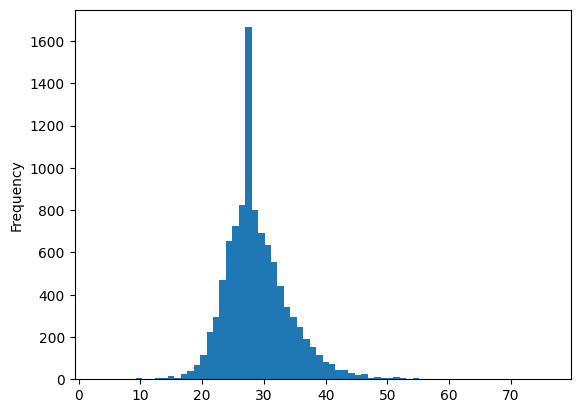

In [88]:
df['Emeklilik için Geçecek Yıllar'].plot.hist(bins=70)

### Girdiler ve Emeklilik Yılları Olasılık Tablosu

In [89]:
quants = df.quantile([i / 20 for i in range(1, 20)])
stilize_edilmis_df(quants)

,Başlangıç Maaşı,Terfi Sıklığı,Yaşam Maliyeti Artışı,Terfi Zam Oranı,Biriktirme Oranı,Faiz Oranı,Emeklilik için Geçecek Yıllar
0.050000,"43,642 TL",2.5 Yıl,1.18%,7.06%,13.72%,3.30%,21
0.100000,"47,212 TL",3.1 Yıl,1.35%,8.70%,16.13%,3.71%,23
0.150000,"49,614 TL",3.5 Yıl,1.47%,9.92%,17.77%,3.96%,24
0.200000,"51,666 TL",3.8 Yıl,1.56%,10.94%,19.07%,4.15%,25
0.250000,"53,319 TL",4.0 Yıl,1.66%,11.74%,20.28%,4.32%,25
0.300000,"54,834 TL",4.2 Yıl,1.73%,12.47%,21.43%,4.47%,26
0.350000,"56,158 TL",4.4 Yıl,1.80%,13.14%,22.40%,4.60%,27
0.400000,"57,535 TL",4.6 Yıl,1.86%,13.80%,23.35%,4.73%,27
0.450000,"58,735 TL",4.8 Yıl,1.92%,14.38%,24.24%,4.86%,28
0.500000,"59,985 TL",5.0 Yıl,1.99%,14.98%,25.06%,4.99%,28


Çıktı, her bir kuantilin karşılık(yüzdeliğin) geldiği değerleri içeren bir tablodur.

Her satır, farklı bir yüzdeliği temsil eder. Örneğin, 0.05 (veya %5) satırı, tüm değerlerin %5'inin bu değerin altında olduğu anlamına gelir. Bu, genellikle "5. yüzdelik" olarak adlandırılır. Benzer şekilde, 0.50 (veya %50) satırı, tüm değerlerin yarısının bu değerin altında olduğu anlamına gelir. Bu, genellikle "medyan" olarak adlandırılır.



### Girdilerin Emeklilik Yıllarına Göre Grafiği

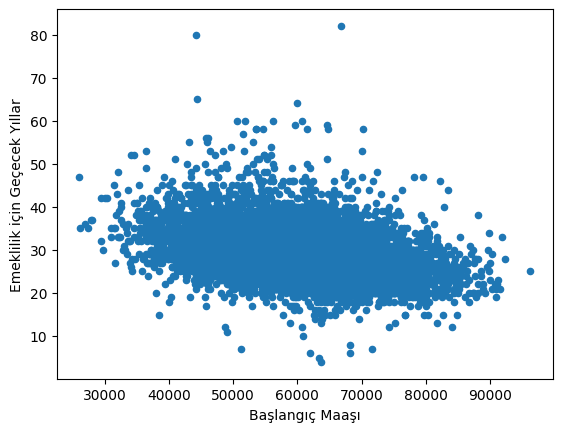

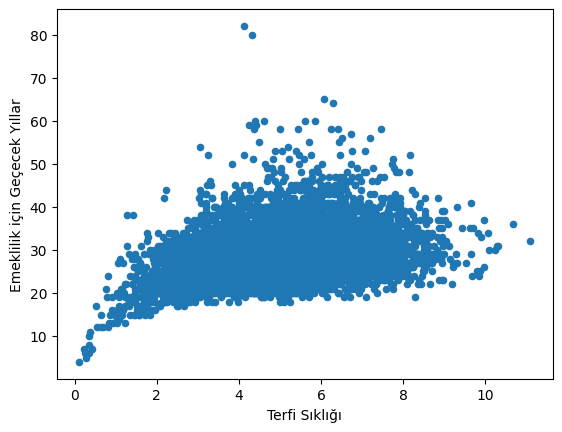

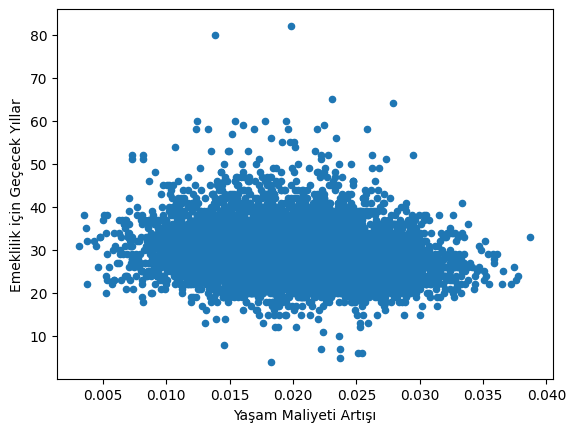

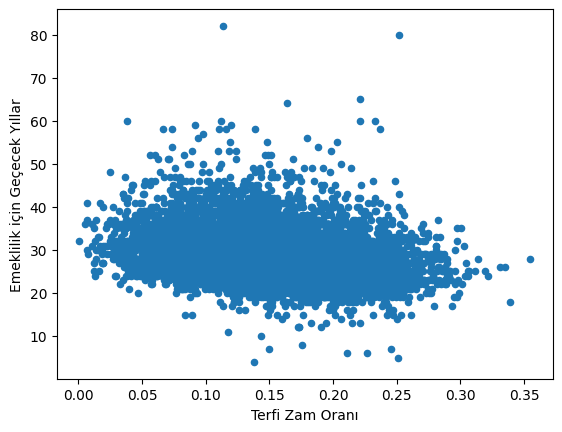

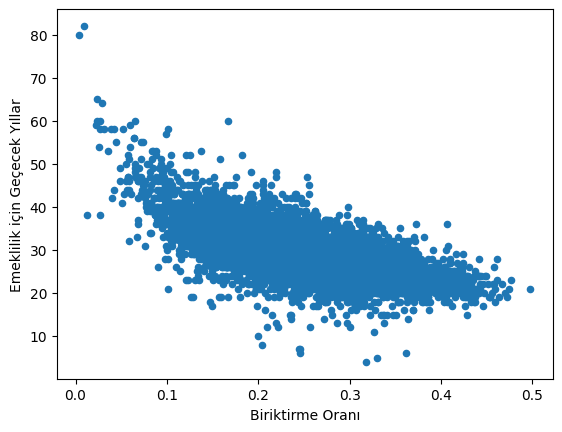

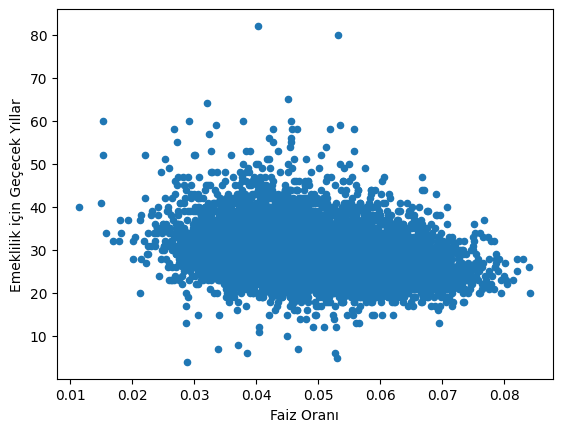

In [55]:
input_cols = [
    'Başlangıç Maaşı', 
    'Terfi Sıklığı', 
    'Yaşam Maliyeti Artışı', 
    'Terfi Zam Oranı', 
    'Biriktirme Oranı', 
    'Faiz Oranı',
]

for col in input_cols:
    df.plot.scatter(y='Emeklilik için Geçecek Yıllar', x=col)

## Sonuçların Analizi

### Çok Değişkenli Regresyon

Şimdi, tüm girdilerin simülasyonda değiştirildiği durumda her bir çıktıyı ne kadar etkilediğini göreceğiz.

In [90]:

output_col = 'Emeklilik için Geçecek Yıllar'

X = sm.add_constant(df[input_cols])
y = df[output_col]

mod = sm.OLS(y, X)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Emeklilik için Geçecek Yıllar   R-squared:                       0.882
Model:                                       OLS   Adj. R-squared:                  0.882
Method:                            Least Squares   F-statistic:                 1.248e+04
Date:                           Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                                   15:53:54   Log-Likelihood:                -20494.
No. Observations:                          10000   AIC:                         4.100e+04
Df Residuals:                               9993   BIC:                         4.105e+04
Df Model:                                      6                                         
Covariance Type:                       nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    63.5266      0.200    317.616      0.000      63.135      63.919
Başlangıç Maaşı          -0.0002    1.9e-06   -105.839      0.000      -0.000      -0.000
Terfi Sıklığı             1.2570      0.012    100.623      0.000       1.232       1.281
Yaşam Maliyeti Artışı  -173.0193      3.758    -46.040      0.000    -180.386    -165.653
Terfi Zam Oranı         -27.6950      0.381    -72.596      0.000     -28.443     -26.947
Biriktirme Oranı        -52.7637      0.267   -197.752      0.000     -53.287     -52.241
Faiz Oranı             -160.1096      1.860    -86.067      0.000    -163.756    -156.463
==============================================================================
Omnibus:                     4910.877   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           673621.395
Skew:                           1.334   Prob(JB):                         0.00
Kurtosis:                      43.120   Cond. No.                     1.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

P değerlerine göre, tüm girdilerin çıktılarla önemli ölçüde ilişkili olduğunu görebiliriz. Ancak, en büyük etkiye sahip olanı anlamak için girdilerin standart sapmalarını da dikkate almalıyız.

In [91]:
df.std()

Başlangıç Maaşı                  9907.089805
Terfi Sıklığı                       1.504849
Yaşam Maliyeti Artışı               0.005001
Terfi Zam Oranı                     0.049264
Biriktirme Oranı                    0.070462
Faiz Oranı                          0.010104
Emeklilik için Geçecek Yıllar       5.474207
dtype: float64

In [92]:
result.params * df.std()

Başlangıç Maaşı                 -1.989945
Biriktirme Oranı                -3.717859
Emeklilik için Geçecek Yıllar         NaN
Faiz Oranı                      -1.617735
Terfi Sıklığı                    1.891541
Terfi Zam Oranı                 -1.364375
Yaşam Maliyeti Artışı           -0.865298
const                                 NaN
dtype: float64

Tasarruf oranının en büyük etkiye sahip olduğu görülüyor. Tasarruf oranındaki bir standart sapma (7%) artışı, emeklilik yıllarını 3.7 yıl azaltıyor. Yaşam maliyeti artışları ise en az etkili olanıdır; yaşam maliyeti artışlarında bir standart sapma artışı (%0.5) sadece emeklilik yıllarını 0.9 yıl azaltır.